In [59]:
# common imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning imports
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# display setup
plt.style.use('seaborn') # for plots
# sns.set(style="whitegrid")

# Preface
* Fashion-MNIST is a dataset containing 70,000 samples, 60,000 for the training set and 10,000 for the test set.
* Each sample is a 28x28 (784 pixels) grayscale image of a certain fashion item.
* The data contains a column with 10 labels, making this a **multiclass classification** problem.
In other words, this is a **supervised learning** task.
* The model will be trained using all available data and run without learning anymore. This method is named **offline/batch learning**.
* Main objective: Find the best algorithm and model parameters that classify the unused images correctly.

# 1. Getting the Data

In [2]:
# read the csv file
train_set = pd.read_csv(r"FMNIST/fashion-mnist_train.csv")
test_set = pd.read_csv(r"FMNIST/fashion-mnist_test.csv")

In [3]:
# display the first 5 rows for a quick look
train_set.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# display the last 5 rows for a quick look
train_set.tail()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
59995,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,1,0,0,0,0,0,0,0,0,0,...,73,0,0,0,0,0,0,0,0,0
59997,8,0,0,0,0,0,0,0,0,0,...,160,162,163,135,94,0,0,0,0,0
59998,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59999,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# DataFrame shape (rows, columns)
print("Training Set:", train_set.shape)
print("Test Set:", test_set.shape)

Training Set: (60000, 785)
Test Set: (10000, 785)


In [6]:
# description of data
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 359.3 MB


In [7]:
# summary of the numerical attributes
# null values are ignored
train_set.describe()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,...,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.00000
mean,4.500000,0.000900,0.006150,0.035333,0.101933,0.247967,0.411467,0.805767,2.198283,5.682000,...,34.625400,23.300683,16.588267,17.869433,22.814817,17.911483,8.520633,2.753300,0.855517,0.07025
std,2.872305,0.094689,0.271011,1.222324,2.452871,4.306912,5.836188,8.215169,14.093378,23.819481,...,57.545242,48.854427,41.979611,43.966032,51.830477,45.149388,29.614859,17.397652,9.356960,2.12587
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,4.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,58.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,9.000000,16.000000,36.000000,226.000000,164.000000,227.000000,230.000000,224.000000,255.000000,254.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,170.00000


In [8]:
# maximum pixel value
train_set.describe().loc['max'].max()

255.0

In [9]:
# minimum pixel value
train_set.describe().loc['min'].max()

0.0

> ### Features in the DataFrame:
> There are 785 columns, one for the labels and 784 for the pixels (one for each pixel).
>> Labels:
> - 0 = T-shirt/top
> - 1 = Trouser
> - 2 = Pullover
> - 3 = Dress
> - 4 = Coat
> - 5 = Sandal
> - 6 = Shirt
> - 7 = Sneaker
> - 8 = Bag
> - 9 = Ankle boot

In [12]:
labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
# number of instances for each category
train_set["label"].value_counts().sort_index()

0    6000
1    6000
2    6000
3    6000
4    6000
5    6000
6    6000
7    6000
8    6000
9    6000
Name: label, dtype: int64

> Initial observations:
>> 1. Each category has an equal amount of samples in the training set.
2. Classes and pixel values are integers.
3. The pixel range is [0, 255]. Some feature columns have a smaller maximum value or a
greater minimum value. This means that the range is reduced for all training instances in
that specific feature, in this case being a pixel value.

# 2. Understanding and Visualizing the Data
> ##### *The motivation for this section is to gain more insights.*

The data was split in advance and the images are already the same size.
Let's create a copy of the data to prevent accidentally harming the training set.

In [79]:
# deep copy of the training set
fmnist = train_set.copy()

In [80]:
# DataFrame shape (rows, columns)
# understand the amount of data we are working with
fmnist.shape

(60000, 785)

In [81]:
# check for missing values
np.isnan(fmnist.values).sum()

0

> #### Observations:
>> * There are no missing values in the training set.

> ### Exploring Colors of Sample Image

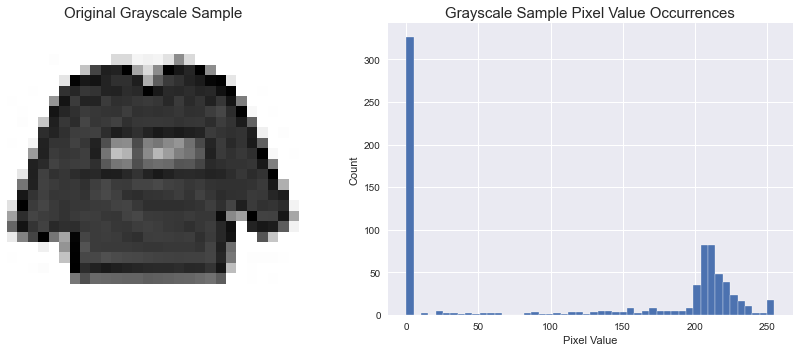

In [172]:
# sample image
some_sample = fmnist.drop('label', axis=1).iloc[0] # get sample
some_sample = np.array(some_sample) # convert to array
some_sample_img = some_sample.reshape(28,28) # reshape array

# plot grayscale sample image and pixel value occurrences
fig, dx = plt.subplots(1,2, figsize=(12, 5))
dx[0].imshow(some_sample_img)
dx[0].axis('off')
dx[0].set_title("Original Grayscale Sample", size= 15)
dx[1].hist(some_sample, bins=50)
dx[1].set_title("Grayscale Sample Pixel Value Occurrences", size= 15)
dx[1].set_xlabel("Pixel Value")
dx[1].set_ylabel("Count")
plt.tight_layout()
plt.show()

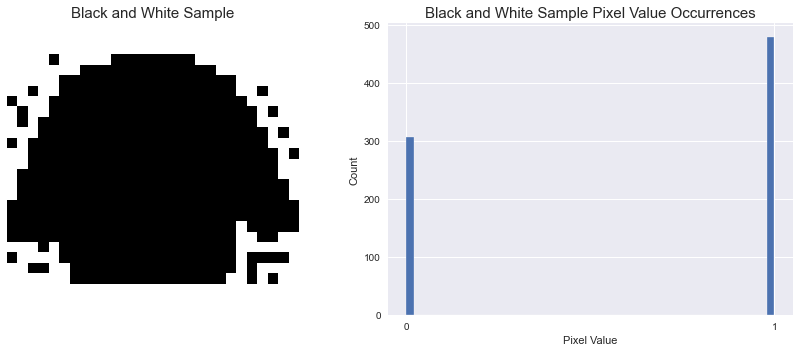

In [175]:
# convert sample image from grayscale to black and white
# in the fashion mnist dataset white pixels are 0 and black pixels are 255
# the images are grayscale, so values (0,255) are different intensities of gray
some_sample_bin = some_sample.copy() # deep copy of the sample image
some_sample_bin[some_sample>0] = 1 # convert gray intensities to black
some_sample_bin_img = some_sample_bin.reshape(28,28) # reshape array

# plot black and white sample image and pixel value occurrences
fig, dx = plt.subplots(1,2, figsize=(12, 5))
dx[0].imshow(some_sample_bin_img)
dx[0].axis('off')
dx[0].set_title("Black and White Sample", size= 15)
dx[1].hist(some_sample_bin, bins=50)
dx[1].set_title("Black and White Sample Pixel Value Occurrences", size= 15)
dx[1].set_xticks([0,1])
dx[1].set_xlabel("Pixel Value")
dx[1].set_ylabel("Count")
plt.tight_layout()
plt.show()

> #### Observations:
>> * The most common pixel value in the original grayscale sample is white (0) and in the binary
> sample is black (1).
* Aside from a few pixels that are detached from the clothing, the item resembles the original grayscale shape.
* Transforming the data from grayscale to black and white should be further evaluated during model training.
There is a possibly it could improve the result.

> ### Class Comparison

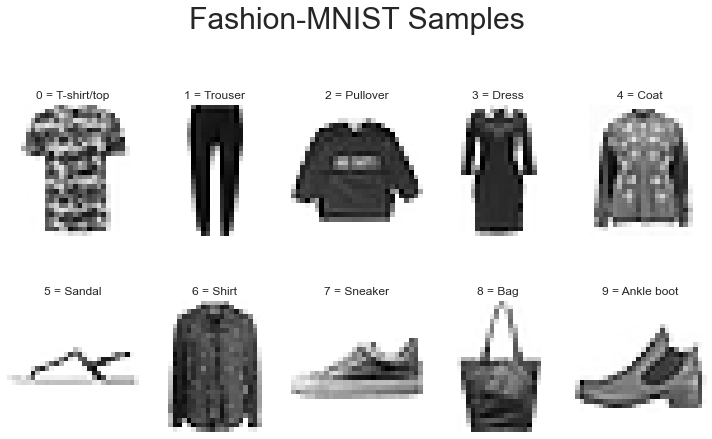

In [184]:
# plot image for each category

# use of a dictionary to easily add subplot titles
label_dict = {0:"0 = T-shirt/top", 1:"1 = Trouser", 2:"2 = Pullover", 3:"3 = Dress", 4:"4 = Coat",
              5:"5 = Sandal", 6:"6 = Shirt", 7:"7 = Sneaker", 8:"8 = Bag", 9:"9 = Ankle boot"}

fig = plt.figure(figsize=(10,7))
rows = 2
columns = 5
# use groupby to locate an instance for each label
label_groups = fmnist.groupby('label')
# add image in each iteration
for i in range(rows*columns):
    curr = label_groups.get_group(i)[:1] # get group
    curr_img = curr.drop('label', axis = 1).to_numpy().reshape(28,28) # convert to reshaped array
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(curr_img)
    plt.axis('off') # remove grid
    plt.title(label_dict[i]) # use dictionary to add subplot title

fig.suptitle("Fashion-MNIST Samples", size=30)
plt.tight_layout()
plt.show()

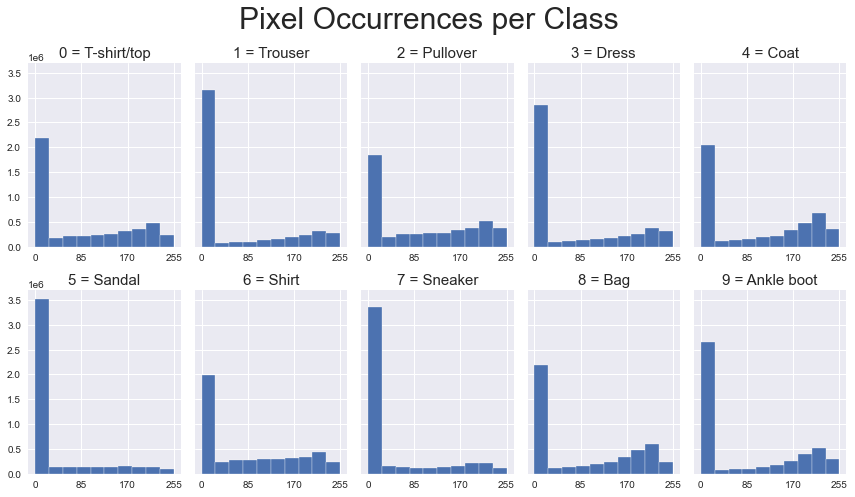

In [189]:
# plot pixel value occurrences for each class

fig, dx = plt.subplots(2,5, figsize=(12, 7), sharey='all')
i = 0 # current group label
mean_values = []
plt.setp(dx, xticks=np.arange(0, 256, step=85)) # set x axis values

for row in range(2):
    for col in range(5):
        pixels = np.array(label_groups.get_group(i).drop(['label'], axis=1)) # get group and convert to array
        mean_values.append(pixels.mean()) # calculate mean pixel value and add to list (for next plot)
        dx[row,col].hist(pixels.reshape(-1)) # add histogram in each iteration, -1 reshapes to length of array
        dx[row,col].set_title(label_dict[i], size=15) # use dictionary to add subplot title
        i = i + 1 # next group

fig.suptitle("Pixel Occurrences per Class", size=30)
plt.tight_layout()
plt.show()

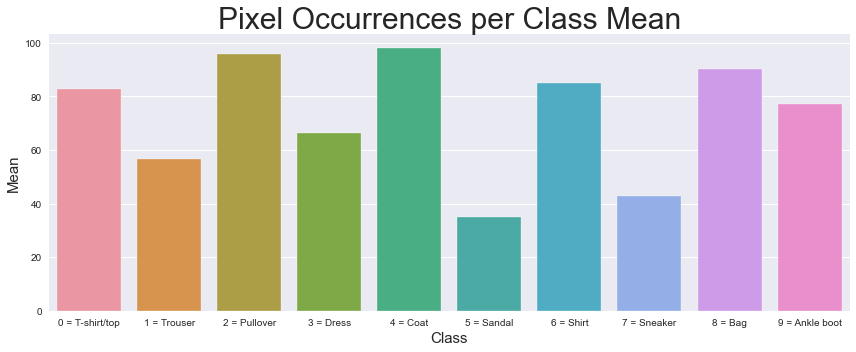

In [186]:
# plot mean values calculated in previous cell
plt.figure(figsize=(12, 5))
sns.barplot(x=np.arange(10), y=mean_values) # x axis for classes, y axis for mean values
plt.xticks(np.arange(10), labels=label_dict.values()) # use dictionary to set x axis values
plt.xlabel("Class", size=15)
plt.ylabel("Mean", size=15)
plt.title("Pixel Occurrences per Class Mean", size=30)
plt.tight_layout()
plt.show()

# 3. Data Cleaning

In [17]:
# clean copy of the training set
df3 = train_set.copy()

In [103]:
# separate features from target values

# drop- creates a copy without changing the training set
X_train = df3.drop('label', axis=1)

# create a deep copy of the target values
y_train = df3['label'].copy()

Although the pixel values are in a known range [0,255], scaling the data can make a crucial difference
(especially if the learning algorithm relies on calculating distances).

> Why is this important?
* Models can't differentiate feature importance the same way humans can.
A training algorithm may assume that a feature containing large numbers is more important than features
with smaller numbers- which might not be the case.
* Some algorithms converge much faster when features are scaled (i.e. Gradient Descent).
* There are ML algorithms that make assumptions on the data (i.e. PCA assumes the data is centered around
the origin).
>

Chosen feature scale:

Standardizing centers the data so that it has a zero mean and a standard deviation of 1, under the assumption
that the data is normally distributed.

* The distribution is relatively normal (aside from the black pixels which is highest in all classes).
* Using PCA could be useful since the dataset has a large amount of features. As previously stated,
PCA assumes the data has zero mean.

Therefore, standard scaling seems to be the ideal option.

# 4. Training and Evaluating Models

>

> Accuracy is less relevant for an imbalanced classification problem.
> Evaluating by a metric that represents the data better is important.
>
> Chosen evaluation metric:
>
> The F1 Score is calculated by using precision (the accuracy of the positive predictions) and
> recall (the ratio of positive instances correctly classified) accuracy.
> This metric gives a higher value towards false positives rather than false negatives.

In [19]:
# function prints scores
def display_evaluation(actual, pred):
    print("Confusion Matrix:\n", metrics.confusion_matrix(actual, pred), "\n")
    print("Classification Report:\n", metrics.classification_report(actual, pred))

In [20]:
log_reg = LogisticRegression(random_state=42, n_jobs=-1, multi_class='ovr')

In [21]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [22]:
skfolds = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)

In [23]:
for train_index, test_index in skfolds.split(X_train, y_train):
    clone_clf = clone(log_reg)
    X_train_folds = X_train.loc[train_index]
    y_train_folds = y_train.loc[train_index]
    X_test_fold = X_train.loc[test_index]
    y_test_fold = y_train.loc[test_index]
    print(y_train_folds.value_counts())
    print(y_test_fold.value_counts())

    std_scl = StandardScaler()
    std_scl.fit_transform(X_train_folds)
    std_scl.transform(X_test_fold)

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred_proba = clone_clf.predict_proba(X_test_fold)
    y_pred = clone_clf.predict(X_test_fold)
    print(metrics.roc_auc_score(y_test_fold, y_pred_proba, multi_class='ovr'))
    print(metrics.accuracy_score(y_test_fold, y_pred))
  #  n_correct = sum(y_pred == y_test_fold)
  #  print(n_correct / len(y_pred))
    print()

0    5000
1    5000
2    5000
3    5000
4    5000
5    5000
6    5000
7    5000
8    5000
9    5000
Name: label, dtype: int64
0    1000
8    1000
1    1000
9    1000
2    1000
3    1000
4    1000
5    1000
6    1000
7    1000
Name: label, dtype: int64


KeyboardInterrupt: 

In [ ]:
knn_clf = KNeighborsClassifier(n_jobs=-1)

In [ ]:
for train_index, test_index in skfolds.split(X_train, y_train):
    clone_clf = clone(knn_clf)
    X_train_folds = X_train.loc[train_index]
    y_train_folds = y_train.loc[train_index]
    X_test_fold = X_train.loc[test_index]
    y_test_fold = y_train.loc[test_index]

    std_scl = StandardScaler()
    std_scl.fit_transform(X_train_folds)
    std_scl.transform(X_test_fold)

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred_proba = clone_clf.predict_proba(X_test_fold)
    y_pred = clone_clf.predict(X_test_fold)
    print(metrics.roc_auc_score(y_test_fold, y_pred_proba, multi_class='ovr'))
    print(metrics.accuracy_score(y_test_fold, y_pred))
  #  n_correct = sum(y_pred == y_test_fold)
  #  print(n_correct / len(y_pred))
    print()

In [ ]:
rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [ ]:
for train_index, test_index in skfolds.split(X_train, y_train):
    clone_clf = clone(rf_clf)
    X_train_folds = X_train.loc[train_index]
    y_train_folds = y_train.loc[train_index]
    X_test_fold = X_train.loc[test_index]
    y_test_fold = y_train.loc[test_index]

    std_scl = StandardScaler()
    std_scl.fit_transform(X_train_folds)
    std_scl.transform(X_test_fold)

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred_proba = clone_clf.predict_proba(X_test_fold)
    y_pred = clone_clf.predict(X_test_fold)
    print(metrics.roc_auc_score(y_test_fold, y_pred_proba, multi_class='ovr'))
    print(metrics.accuracy_score(y_test_fold, y_pred))
  #  n_correct = sum(y_pred == y_test_fold)
  #  print(n_correct / len(y_pred))
    conf_mx = metrics.confusion_matrix(y_test_fold, y_pred)
    plt.matshow(conf_mx, cmap=plt.cm.gray)
    plt.show()
    row_sums = conf_mx.sum(axis=1, keepdims=True)
    norm_conf_mx = conf_mx / row_sums
    np.fill_diagonal(norm_conf_mx, 0)
    plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
    plt.show()
    print()


When gaining insights on the training set I counted the values of each label.

Stratified sampling in cross validation ensures the training and test sets have the same proportion.

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
X_train_scaled = StandardScaler().fit_transform(X_train)

In [ ]:
rf_cv = cross_val_score(rf_clf, X_train_scaled, y_train, cv=6, scoring='accuracy')

In [ ]:
cross_val_score(knn_clf, X_train_scaled, y_train, cv=6, scoring='accuracy')

In [ ]:
cross_val_score(log_reg, X_train_scaled, y_train, cv=6, scoring='accuracy')

In [ ]:
rf_cv.mean()

> #### Resources:
> 1. Fashion MNIST Dataset <a href="https://www.kaggle.com/zalando-research/fashionmnist"
> title="Kaggle">link</a>
> 2. Feature Scaling Article <a href="https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35"
> title="towardsdatascience">link</a>
